The code in the following sections comes mainly from [this repository](https://github.com/tkipf/pygcn) and it is inspired by the paper [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907), where Thomas Kipf presents the Graph Convolutional Networks in PyTorch.

In [1]:
import pandas
import numpy as np
import scipy.sparse as sp
import torch


#The Cora Dataset

##Datset format

The `cora.content` contains the description of each node. For each line it contains:
 - The id of the node.
 - The [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) text representation.
 - The label of that node.

In [2]:
headers = ['PaperID'] + [f'word{i}' for i in range(1433)] + ['label']
cora_content=pandas.read_csv('cora.content', sep="\t", names=headers)
cora_content.head()

,PaperID,word0,word1,word2,word3,word4,word5,word6,word7,word8,...,word1424,word1425,word1426,word1427,word1428,word1429,word1430,word1431,word1432,label
0,31336,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Probabilistic_Methods


The `cora.cites` contains the relationships between nodes. For each line it contains:

- The first entry is id of the cited paper
- The second entry id of the citing paper

That is, the direction of the entry is right to left.

In [3]:
headers = ['Cited PaperID', 'Citing PaperID']
cora_cites=pandas.read_csv('cora.cites', sep="\t", names=headers)
cora_cites.head()

,Cited PaperID,Citing PaperID
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [4]:
classes = [
    'Case_Based',
    'Genetic_Algorithms',
    'Neural_Networks',
    'Probabilistic_Methods',
    'Reinforcement_Learning',
    'Rule_Learning',
    'Theory',
]

## Dataset Loading

Until now we have seen building graphs in networkx. However in Pytorch, we need the data in the form of tensors. For this, we need some pre-processing

In [5]:
def encode_onehot(labels):
    """ Converts categorical labels into a one-hot encoded format"""
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

In [6]:
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

#Row-normalizes a sparse matrix.
#To ensure that the sum of weights for edges originating from a node is 1.

In [ ]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse_coo_tensor(indices, values, shape)

In [ ]:
def load_data(cora_cites, cora_content):
    """Load citation network dataset from pandas DataFrames."""
    print('Loading dataset from DataFrames...')

    # Extract data from cora_content DataFrame
    idx_features_labels = cora_content.values
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}

    # Extract data from cora_cites DataFrame and build edges
    edges_unordered = cora_cites.values
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test

# Now you can call the function with your existing dataframes:
# adj, features, labels, idx_train, idx_val, idx_test = load_data(cora_cites, cora_content)

In [ ]:
adj, features, labels, idx_train, idx_val, idx_test = load_data(cora_cites, cora_content)

Loading dataset from DataFrames...


In [ ]:
# As expected its shape is num_paper*num_paper
adj.shape

torch.Size([2708, 2708])

In [ ]:
print(torch.sum(adj.to_dense(), 0)) #summing across the rows, calculating, sum of each column
print(torch.sum(adj.to_dense(), 1)) #summing across the column, calculating sum of each row

tensor([0.8333, 0.5312, 0.5276,  ..., 1.1444, 1.1524, 1.2000])
tensor([1., 1., 1.,  ..., 1., 1., 1.])


The row normalization makes the "outgoing" weights from each node sum to 1, but it doesn't force the "incoming" weights (represented by column sums) to also sum to 1.

In [ ]:
# Each paper has 1433 features. The BOW representation of its text
features.shape

torch.Size([2708, 1433])

## Graph Convolution


###Graph Convolution Layer


- `GraphConvolution(Module)`: Defines a custom PyTorch module for the graph convolution operation.
  - `__init__`: Initializes the layer with input and output feature sizes. It defines two `nn.Parameter`s: `weight` and `bias`. These are the learnable parameters of the layer.
  - `reset_parameters`: Initializes the weight and bias parameters using a uniform distribution, a standard practice.
  - `forward(input, adj)`: Performs the graph convolution:
    - `support = torch.mm(input, self.weight)`: Multiplies the input features by the weight matrix.
    - `output = torch.spmm(adj, support)`: Performs sparse matrix multiplication between the adjacency matrix and the `support` matrix. This is the core of the graph convolution, aggregating information from neighboring nodes based on the graph structure.
    - `return output + self.bias`: Adds the bias term to the aggregated features.

In [ ]:
from torch import nn
import torch.nn.functional as F # Also import F for ReLU
from torch.nn import Parameter, Module

import math
class GraphConvolution(Module):

    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__() #super() provides a way to access the methods of the parent class (torch.nn.Module).
        """Initializes the layer with input and output feature sizes"""

        # A nn.Parameter is a normal tensor
        # that is automatically registered as a model parameter
        # so that it is inclued in `model.parameters()`.
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = Parameter(torch.FloatTensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        #Initializes the weight and bias parameters using a uniform distribution
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight) #multiplies input features by weight matrix
        output = torch.spmm(adj, support)  # sparse matrix multiplication between the adjacency matrix and the support matrix.
        # This aggregaties information from neighboring nodes based on the graph structure.
        return output + self.bias  #Adds the bias term to the aggregated features.

**Graph Convolutional Network (GCN) Model:**
- `GCN(nn.Module)`: Defines the overall GCN model.
  - `__init__`: Initializes the model with the number of input features (`nfeat`), hidden layer size (`nhid`), number of output classes (`nclass`), and dropout rate. It instantiates two `GraphConvolution` layers.
  - `forward(x, adj)`: Defines the forward pass of the GCN:
    - `x = F.relu(self.gc1(x, adj))`: Applies the first graph convolution layer and then the ReLU activation function.
    - `x = self.gc2(x, adj)`: Applies the second graph convolution layer. The output of this layer is the final prediction scores for each node across the different classes.

In [ ]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass,dropout):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout=dropout

    def forward(self, x, adj):
        h = F.relu(self.gc1(x, adj))
        #x is the input node feature tensor.
        #Its shape is typically (number_of_nodes, number_of_input_features)
        #ad is adjacency matrix in sparse tensor
        z = self.gc2(h, adj)
        return z

In [ ]:
#gcn = GCN(1433, 50, 7)

dropout_rate = 0.5
gcn = GCN(nfeat=features.shape[1], nhid=50, nclass=labels.max().item() + 1, dropout=dropout_rate)


In [ ]:

def compute_accuracy(model, features, adj, labels, indices):
    """
    Computes the accuracy of the model on the data specified by indices.
    """
    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient computation
        output = model(features, adj)
        sliced_output = output[indices]
        sliced_labels = labels[indices]
        preds = sliced_output.max(1)[1].type_as(sliced_labels)
        correct = preds.eq(sliced_labels).double()
        correct = correct.sum()
        acc = correct / len(sliced_labels)
    return acc



In [ ]:
import torch.optim as optim # Import the optim module
from tqdm import trange
import torch.nn.functional as F # Make sure F is imported


# Initialize the optimizer with weight decay
# Choose a weight decay value, e.g., 5e-4
weight_decay_value = 5e-4
opt = optim.Adam(gcn.parameters(), lr=0.01, weight_decay=weight_decay_value) # Add weight_decay

losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Add lists to store best validation accuracy and corresponding test accuracy for early stopping
best_val_acc = 0
best_test_acc = 0
epochs_no_improve = 0
patience = 100 # Number of epochs to wait for improvement before stopping

for epoch in trange(1000):
    gcn.train() # Set model to training mode
    opt.zero_grad()
    output = gcn(features, adj)
    loss = F.cross_entropy(output[idx_train], labels[idx_train])

    loss.backward()
    opt.step()

    losses.append(loss.item())

    # Calculate accuracies
    train_acc = compute_accuracy(gcn, features, adj, labels, idx_train)
    val_acc = compute_accuracy(gcn, features, adj, labels, idx_val)
    test_acc = compute_accuracy(gcn, features, adj, labels, idx_test)


    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())
    test_accuracies.append(test_acc.item())

    # Check for early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc # Store the test accuracy when validation accuracy improves
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Print loss and accuracies for the current epoch
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")


# After the training loop, you can access the lists and the best test accuracy
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Test Accuracy at Best Validation: {best_test_acc:.4f}")



  0%|          | 2/1000 [00:00<01:14, 13.40it/s]

Epoch 1, Loss: 1.9794, Train Acc: 0.1214, Val Acc: 0.1133, Test Acc: 0.1470
Epoch 2, Loss: 1.9436, Train Acc: 0.1214, Val Acc: 0.1133, Test Acc: 0.1470
Epoch 3, Loss: 1.9110, Train Acc: 0.1214, Val Acc: 0.1133, Test Acc: 0.1470


  1%|          | 6/1000 [00:00<01:12, 13.79it/s]

Epoch 4, Loss: 1.8808, Train Acc: 0.2071, Val Acc: 0.1267, Test Acc: 0.1630
Epoch 5, Loss: 1.8517, Train Acc: 0.5286, Val Acc: 0.4400, Test Acc: 0.3440
Epoch 6, Loss: 1.8229, Train Acc: 0.5214, Val Acc: 0.4667, Test Acc: 0.4070


  1%|          | 8/1000 [00:00<01:11, 13.86it/s]

Epoch 7, Loss: 1.7953, Train Acc: 0.4643, Val Acc: 0.4300, Test Acc: 0.3620
Epoch 8, Loss: 1.7686, Train Acc: 0.4357, Val Acc: 0.3967, Test Acc: 0.3440
Epoch 9, Loss: 1.7422, Train Acc: 0.4286, Val Acc: 0.3700, Test Acc: 0.3320


  1%|          | 12/1000 [00:00<01:12, 13.70it/s]

Epoch 10, Loss: 1.7164, Train Acc: 0.4000, Val Acc: 0.3633, Test Acc: 0.3210
Epoch 11, Loss: 1.6911, Train Acc: 0.3571, Val Acc: 0.3567, Test Acc: 0.3180
Epoch 12, Loss: 1.6662, Train Acc: 0.3571, Val Acc: 0.3533, Test Acc: 0.3150


  1%|▏         | 14/1000 [00:01<01:11, 13.78it/s]

Epoch 13, Loss: 1.6416, Train Acc: 0.3500, Val Acc: 0.3500, Test Acc: 0.3140
Epoch 14, Loss: 1.6173, Train Acc: 0.3500, Val Acc: 0.3500, Test Acc: 0.3140
Epoch 15, Loss: 1.5930, Train Acc: 0.3643, Val Acc: 0.3533, Test Acc: 0.3160


  2%|▏         | 18/1000 [00:01<01:10, 13.87it/s]

Epoch 16, Loss: 1.5683, Train Acc: 0.3714, Val Acc: 0.3567, Test Acc: 0.3190
Epoch 17, Loss: 1.5427, Train Acc: 0.4071, Val Acc: 0.3600, Test Acc: 0.3210
Epoch 18, Loss: 1.5156, Train Acc: 0.4357, Val Acc: 0.3667, Test Acc: 0.3270


  2%|▏         | 20/1000 [00:01<01:10, 13.87it/s]

Epoch 19, Loss: 1.4871, Train Acc: 0.4500, Val Acc: 0.3733, Test Acc: 0.3340
Epoch 20, Loss: 1.4573, Train Acc: 0.4643, Val Acc: 0.3933, Test Acc: 0.3420
Epoch 21, Loss: 1.4264, Train Acc: 0.4786, Val Acc: 0.4333, Test Acc: 0.3580


  2%|▏         | 24/1000 [00:01<01:10, 13.75it/s]

Epoch 22, Loss: 1.3949, Train Acc: 0.5286, Val Acc: 0.4767, Test Acc: 0.3740
Epoch 23, Loss: 1.3630, Train Acc: 0.5786, Val Acc: 0.4967, Test Acc: 0.3910
Epoch 24, Loss: 1.3308, Train Acc: 0.6214, Val Acc: 0.5233, Test Acc: 0.4080


  3%|▎         | 26/1000 [00:01<01:12, 13.38it/s]

Epoch 25, Loss: 1.2984, Train Acc: 0.6643, Val Acc: 0.5667, Test Acc: 0.4250
Epoch 26, Loss: 1.2656, Train Acc: 0.7000, Val Acc: 0.5967, Test Acc: 0.4400
Epoch 27, Loss: 1.2324, Train Acc: 0.7143, Val Acc: 0.6233, Test Acc: 0.4640


  3%|▎         | 30/1000 [00:02<01:11, 13.58it/s]

Epoch 28, Loss: 1.1988, Train Acc: 0.7429, Val Acc: 0.6300, Test Acc: 0.4770
Epoch 29, Loss: 1.1649, Train Acc: 0.7786, Val Acc: 0.6367, Test Acc: 0.4880
Epoch 30, Loss: 1.1309, Train Acc: 0.7786, Val Acc: 0.6400, Test Acc: 0.4970


  3%|▎         | 32/1000 [00:02<01:10, 13.67it/s]

Epoch 31, Loss: 1.0971, Train Acc: 0.7857, Val Acc: 0.6633, Test Acc: 0.5070
Epoch 32, Loss: 1.0638, Train Acc: 0.7857, Val Acc: 0.6800, Test Acc: 0.5210
Epoch 33, Loss: 1.0310, Train Acc: 0.8143, Val Acc: 0.6900, Test Acc: 0.5410


  4%|▎         | 36/1000 [00:02<01:10, 13.75it/s]

Epoch 34, Loss: 0.9986, Train Acc: 0.8286, Val Acc: 0.7033, Test Acc: 0.5690
Epoch 35, Loss: 0.9666, Train Acc: 0.8357, Val Acc: 0.7167, Test Acc: 0.5970
Epoch 36, Loss: 0.9351, Train Acc: 0.8429, Val Acc: 0.7400, Test Acc: 0.6350


  4%|▍         | 38/1000 [00:02<01:09, 13.81it/s]

Epoch 37, Loss: 0.9043, Train Acc: 0.8500, Val Acc: 0.7533, Test Acc: 0.6670
Epoch 38, Loss: 0.8744, Train Acc: 0.8786, Val Acc: 0.7767, Test Acc: 0.6920
Epoch 39, Loss: 0.8455, Train Acc: 0.9000, Val Acc: 0.7833, Test Acc: 0.7070


  4%|▍         | 42/1000 [00:03<01:09, 13.75it/s]

Epoch 40, Loss: 0.8175, Train Acc: 0.9071, Val Acc: 0.7833, Test Acc: 0.7210
Epoch 41, Loss: 0.7906, Train Acc: 0.9214, Val Acc: 0.8000, Test Acc: 0.7340
Epoch 42, Loss: 0.7645, Train Acc: 0.9214, Val Acc: 0.8067, Test Acc: 0.7370


  4%|▍         | 44/1000 [00:03<01:09, 13.82it/s]

Epoch 43, Loss: 0.7396, Train Acc: 0.9286, Val Acc: 0.8100, Test Acc: 0.7410
Epoch 44, Loss: 0.7157, Train Acc: 0.9357, Val Acc: 0.8167, Test Acc: 0.7470
Epoch 45, Loss: 0.6930, Train Acc: 0.9357, Val Acc: 0.8167, Test Acc: 0.7550


  5%|▍         | 48/1000 [00:03<01:08, 13.83it/s]

Epoch 46, Loss: 0.6712, Train Acc: 0.9357, Val Acc: 0.8067, Test Acc: 0.7640
Epoch 47, Loss: 0.6505, Train Acc: 0.9357, Val Acc: 0.8133, Test Acc: 0.7720
Epoch 48, Loss: 0.6308, Train Acc: 0.9429, Val Acc: 0.8133, Test Acc: 0.7780


  5%|▌         | 50/1000 [00:03<01:08, 13.82it/s]

Epoch 49, Loss: 0.6122, Train Acc: 0.9500, Val Acc: 0.8167, Test Acc: 0.7800
Epoch 50, Loss: 0.5946, Train Acc: 0.9500, Val Acc: 0.8167, Test Acc: 0.7870
Epoch 51, Loss: 0.5779, Train Acc: 0.9571, Val Acc: 0.8167, Test Acc: 0.7940


  5%|▌         | 54/1000 [00:03<01:09, 13.70it/s]

Epoch 52, Loss: 0.5620, Train Acc: 0.9571, Val Acc: 0.8200, Test Acc: 0.7960
Epoch 53, Loss: 0.5470, Train Acc: 0.9571, Val Acc: 0.8200, Test Acc: 0.7970
Epoch 54, Loss: 0.5328, Train Acc: 0.9571, Val Acc: 0.8200, Test Acc: 0.8020


  6%|▌         | 56/1000 [00:04<01:07, 13.91it/s]

Epoch 55, Loss: 0.5194, Train Acc: 0.9571, Val Acc: 0.8233, Test Acc: 0.8000
Epoch 56, Loss: 0.5067, Train Acc: 0.9571, Val Acc: 0.8200, Test Acc: 0.8080
Epoch 57, Loss: 0.4947, Train Acc: 0.9571, Val Acc: 0.8200, Test Acc: 0.8120


  6%|▌         | 60/1000 [00:04<01:06, 14.07it/s]

Epoch 58, Loss: 0.4834, Train Acc: 0.9571, Val Acc: 0.8167, Test Acc: 0.8130
Epoch 59, Loss: 0.4727, Train Acc: 0.9571, Val Acc: 0.8167, Test Acc: 0.8160
Epoch 60, Loss: 0.4626, Train Acc: 0.9571, Val Acc: 0.8167, Test Acc: 0.8160


  6%|▌         | 62/1000 [00:04<01:07, 13.92it/s]

Epoch 61, Loss: 0.4529, Train Acc: 0.9643, Val Acc: 0.8167, Test Acc: 0.8180
Epoch 62, Loss: 0.4438, Train Acc: 0.9643, Val Acc: 0.8167, Test Acc: 0.8210
Epoch 63, Loss: 0.4351, Train Acc: 0.9643, Val Acc: 0.8133, Test Acc: 0.8210


  7%|▋         | 66/1000 [00:04<01:06, 14.01it/s]

Epoch 64, Loss: 0.4268, Train Acc: 0.9643, Val Acc: 0.8133, Test Acc: 0.8240
Epoch 65, Loss: 0.4189, Train Acc: 0.9643, Val Acc: 0.8167, Test Acc: 0.8230
Epoch 66, Loss: 0.4114, Train Acc: 0.9643, Val Acc: 0.8167, Test Acc: 0.8240


  7%|▋         | 68/1000 [00:04<01:08, 13.58it/s]

Epoch 67, Loss: 0.4042, Train Acc: 0.9643, Val Acc: 0.8167, Test Acc: 0.8250
Epoch 68, Loss: 0.3974, Train Acc: 0.9643, Val Acc: 0.8167, Test Acc: 0.8280
Epoch 69, Loss: 0.3908, Train Acc: 0.9643, Val Acc: 0.8200, Test Acc: 0.8290


  7%|▋         | 72/1000 [00:05<01:07, 13.75it/s]

Epoch 70, Loss: 0.3845, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8290
Epoch 71, Loss: 0.3785, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8280
Epoch 72, Loss: 0.3727, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8290


  7%|▋         | 74/1000 [00:05<01:06, 13.85it/s]

Epoch 73, Loss: 0.3672, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8290
Epoch 74, Loss: 0.3619, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8290
Epoch 75, Loss: 0.3568, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8290


  8%|▊         | 78/1000 [00:05<01:06, 13.88it/s]

Epoch 76, Loss: 0.3519, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8300
Epoch 77, Loss: 0.3471, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8290
Epoch 78, Loss: 0.3426, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8280


  8%|▊         | 80/1000 [00:05<01:05, 13.94it/s]

Epoch 79, Loss: 0.3382, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8280
Epoch 80, Loss: 0.3340, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8300
Epoch 81, Loss: 0.3299, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8310


  8%|▊         | 84/1000 [00:06<01:06, 13.68it/s]

Epoch 82, Loss: 0.3259, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8320
Epoch 83, Loss: 0.3221, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8300
Epoch 84, Loss: 0.3184, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8300


  9%|▊         | 86/1000 [00:06<01:06, 13.74it/s]

Epoch 85, Loss: 0.3148, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8290
Epoch 86, Loss: 0.3114, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8300
Epoch 87, Loss: 0.3080, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8300


  9%|▉         | 88/1000 [00:06<01:10, 12.91it/s]

Epoch 88, Loss: 0.3047, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8310
Epoch 89, Loss: 0.3016, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8320


  9%|▉         | 90/1000 [00:06<01:18, 11.65it/s]

Epoch 90, Loss: 0.2985, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8320
Epoch 91, Loss: 0.2954, Train Acc: 0.9786, Val Acc: 0.8167, Test Acc: 0.8310


  9%|▉         | 92/1000 [00:06<01:23, 10.91it/s]

Epoch 92, Loss: 0.2925, Train Acc: 0.9786, Val Acc: 0.8167, Test Acc: 0.8310
Epoch 93, Loss: 0.2896, Train Acc: 0.9786, Val Acc: 0.8167, Test Acc: 0.8310


  9%|▉         | 94/1000 [00:07<01:27, 10.33it/s]

Epoch 94, Loss: 0.2868, Train Acc: 0.9786, Val Acc: 0.8167, Test Acc: 0.8310
Epoch 95, Loss: 0.2841, Train Acc: 0.9786, Val Acc: 0.8200, Test Acc: 0.8330


 10%|▉         | 96/1000 [00:07<01:30,  9.99it/s]

Epoch 96, Loss: 0.2814, Train Acc: 0.9786, Val Acc: 0.8200, Test Acc: 0.8330
Epoch 97, Loss: 0.2788, Train Acc: 0.9786, Val Acc: 0.8200, Test Acc: 0.8330


 10%|▉         | 99/1000 [00:07<01:33,  9.67it/s]

Epoch 98, Loss: 0.2762, Train Acc: 0.9786, Val Acc: 0.8200, Test Acc: 0.8330
Epoch 99, Loss: 0.2737, Train Acc: 0.9786, Val Acc: 0.8200, Test Acc: 0.8320


 10%|█         | 101/1000 [00:07<01:34,  9.49it/s]

Epoch 100, Loss: 0.2713, Train Acc: 0.9786, Val Acc: 0.8200, Test Acc: 0.8320
Epoch 101, Loss: 0.2689, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8300


 10%|█         | 103/1000 [00:08<01:37,  9.23it/s]

Epoch 102, Loss: 0.2665, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8290
Epoch 103, Loss: 0.2642, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8290


 10%|█         | 105/1000 [00:08<01:40,  8.94it/s]

Epoch 104, Loss: 0.2619, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8290
Epoch 105, Loss: 0.2597, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8290


 11%|█         | 107/1000 [00:08<01:42,  8.72it/s]

Epoch 106, Loss: 0.2575, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8290
Epoch 107, Loss: 0.2554, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8270


 11%|█         | 109/1000 [00:08<01:40,  8.90it/s]

Epoch 108, Loss: 0.2533, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8280
Epoch 109, Loss: 0.2512, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8290


 11%|█         | 111/1000 [00:08<01:38,  8.99it/s]

Epoch 110, Loss: 0.2492, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8290
Epoch 111, Loss: 0.2472, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8280


 11%|█▏        | 113/1000 [00:09<01:39,  8.93it/s]

Epoch 112, Loss: 0.2453, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8300
Epoch 113, Loss: 0.2434, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8300


 12%|█▏        | 115/1000 [00:09<01:26, 10.21it/s]

Epoch 114, Loss: 0.2415, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8310
Epoch 115, Loss: 0.2397, Train Acc: 0.9857, Val Acc: 0.8133, Test Acc: 0.8300
Epoch 116, Loss: 0.2379, Train Acc: 0.9857, Val Acc: 0.8133, Test Acc: 0.8300


 12%|█▏        | 119/1000 [00:09<01:11, 12.28it/s]

Epoch 117, Loss: 0.2361, Train Acc: 0.9857, Val Acc: 0.8100, Test Acc: 0.8300
Epoch 118, Loss: 0.2344, Train Acc: 0.9857, Val Acc: 0.8133, Test Acc: 0.8300
Epoch 119, Loss: 0.2327, Train Acc: 0.9857, Val Acc: 0.8133, Test Acc: 0.8300


 12%|█▏        | 121/1000 [00:09<01:08, 12.86it/s]

Epoch 120, Loss: 0.2310, Train Acc: 0.9857, Val Acc: 0.8100, Test Acc: 0.8290
Epoch 121, Loss: 0.2294, Train Acc: 0.9857, Val Acc: 0.8100, Test Acc: 0.8300
Epoch 122, Loss: 0.2278, Train Acc: 0.9857, Val Acc: 0.8100, Test Acc: 0.8320


 12%|█▎        | 125/1000 [00:10<01:03, 13.67it/s]

Epoch 123, Loss: 0.2262, Train Acc: 0.9857, Val Acc: 0.8100, Test Acc: 0.8310
Epoch 124, Loss: 0.2247, Train Acc: 0.9857, Val Acc: 0.8100, Test Acc: 0.8310
Epoch 125, Loss: 0.2231, Train Acc: 0.9857, Val Acc: 0.8100, Test Acc: 0.8310


 13%|█▎        | 127/1000 [00:10<01:02, 13.88it/s]

Epoch 126, Loss: 0.2216, Train Acc: 0.9857, Val Acc: 0.8100, Test Acc: 0.8310
Epoch 127, Loss: 0.2201, Train Acc: 0.9857, Val Acc: 0.8100, Test Acc: 0.8310
Epoch 128, Loss: 0.2187, Train Acc: 0.9857, Val Acc: 0.8100, Test Acc: 0.8310


 13%|█▎        | 131/1000 [00:10<01:03, 13.64it/s]

Epoch 129, Loss: 0.2173, Train Acc: 0.9857, Val Acc: 0.8100, Test Acc: 0.8310
Epoch 130, Loss: 0.2159, Train Acc: 0.9857, Val Acc: 0.8100, Test Acc: 0.8310
Epoch 131, Loss: 0.2145, Train Acc: 0.9857, Val Acc: 0.8033, Test Acc: 0.8310


 13%|█▎        | 133/1000 [00:10<01:03, 13.70it/s]

Epoch 132, Loss: 0.2131, Train Acc: 0.9857, Val Acc: 0.8033, Test Acc: 0.8310
Epoch 133, Loss: 0.2118, Train Acc: 0.9857, Val Acc: 0.8033, Test Acc: 0.8310
Epoch 134, Loss: 0.2105, Train Acc: 0.9857, Val Acc: 0.8033, Test Acc: 0.8310


 14%|█▎        | 137/1000 [00:10<01:01, 13.93it/s]

Epoch 135, Loss: 0.2092, Train Acc: 0.9857, Val Acc: 0.8033, Test Acc: 0.8300
Epoch 136, Loss: 0.2080, Train Acc: 0.9857, Val Acc: 0.8033, Test Acc: 0.8310
Epoch 137, Loss: 0.2067, Train Acc: 0.9857, Val Acc: 0.8033, Test Acc: 0.8300


 14%|█▍        | 139/1000 [00:11<01:05, 13.21it/s]

Epoch 138, Loss: 0.2055, Train Acc: 0.9857, Val Acc: 0.8033, Test Acc: 0.8300
Epoch 139, Loss: 0.2043, Train Acc: 0.9857, Val Acc: 0.8033, Test Acc: 0.8300
Epoch 140, Loss: 0.2032, Train Acc: 0.9929, Val Acc: 0.8067, Test Acc: 0.8300


 14%|█▍        | 143/1000 [00:11<01:04, 13.32it/s]

Epoch 141, Loss: 0.2020, Train Acc: 0.9857, Val Acc: 0.8067, Test Acc: 0.8300
Epoch 142, Loss: 0.2009, Train Acc: 0.9929, Val Acc: 0.8033, Test Acc: 0.8310
Epoch 143, Loss: 0.1998, Train Acc: 0.9929, Val Acc: 0.8067, Test Acc: 0.8300


 14%|█▍        | 145/1000 [00:11<01:04, 13.31it/s]

Epoch 144, Loss: 0.1987, Train Acc: 0.9929, Val Acc: 0.8067, Test Acc: 0.8310
Epoch 145, Loss: 0.1976, Train Acc: 0.9929, Val Acc: 0.8067, Test Acc: 0.8320
Epoch 146, Loss: 0.1966, Train Acc: 0.9929, Val Acc: 0.8067, Test Acc: 0.8320


 15%|█▍        | 149/1000 [00:11<01:02, 13.71it/s]

Epoch 147, Loss: 0.1955, Train Acc: 0.9929, Val Acc: 0.8067, Test Acc: 0.8340
Epoch 148, Loss: 0.1945, Train Acc: 0.9929, Val Acc: 0.8067, Test Acc: 0.8320
Epoch 149, Loss: 0.1935, Train Acc: 0.9929, Val Acc: 0.8067, Test Acc: 0.8330


 15%|█▌        | 151/1000 [00:11<01:01, 13.78it/s]

Epoch 150, Loss: 0.1925, Train Acc: 0.9929, Val Acc: 0.8067, Test Acc: 0.8320
Epoch 151, Loss: 0.1916, Train Acc: 0.9929, Val Acc: 0.8067, Test Acc: 0.8350
Epoch 152, Loss: 0.1906, Train Acc: 0.9929, Val Acc: 0.8067, Test Acc: 0.8340


 15%|█▌        | 154/1000 [00:12<01:07, 12.59it/s]

Epoch 153, Loss: 0.1897, Train Acc: 0.9929, Val Acc: 0.8067, Test Acc: 0.8320
Epoch 154, Loss: 0.1888, Train Acc: 0.9929, Val Acc: 0.8067, Test Acc: 0.8350
Early stopping at epoch 155
Best Validation Accuracy: 0.8233
Test Accuracy at Best Validation: 0.8000


In [ ]:
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of parameters GCN: ', num_params(gcn))

Number of parameters GCN:  72057


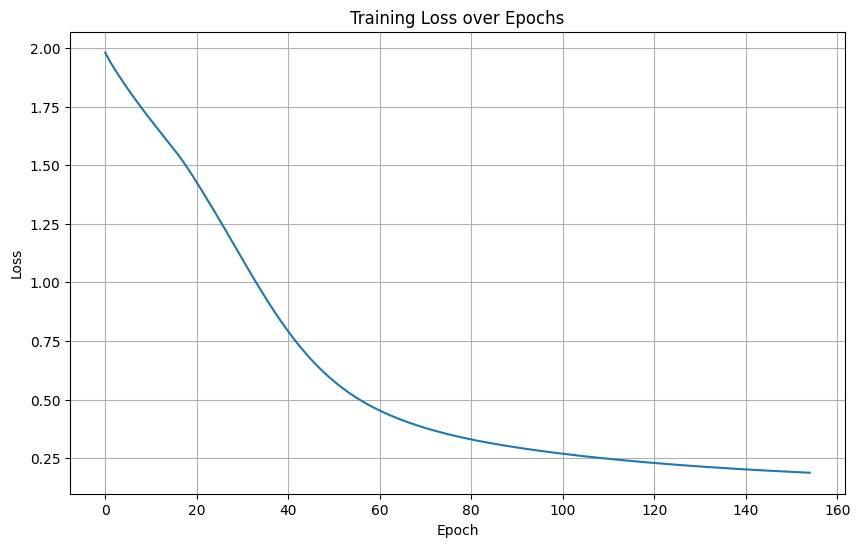

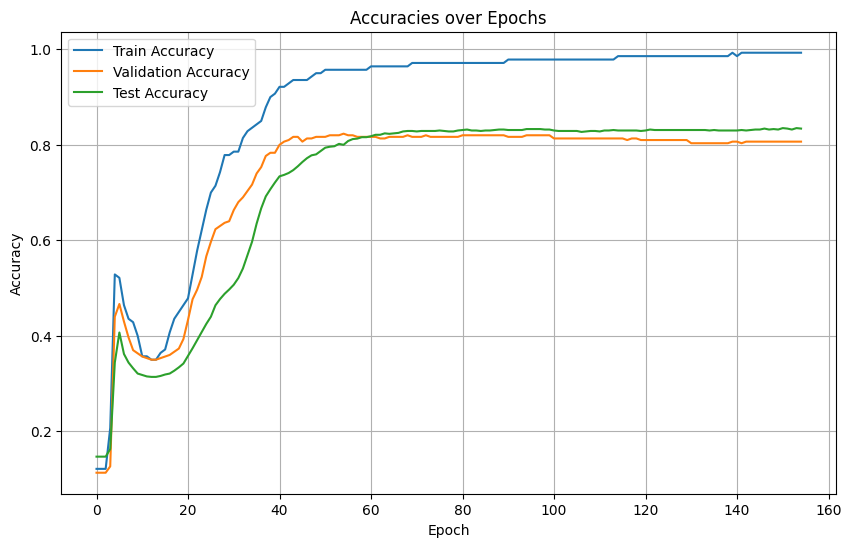

In [ ]:
# prompt: add some visulaization of the losses, accuracies

import matplotlib.pyplot as plt

# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracies over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# prompt: show some correct classification on the test data

gcn.eval()
output = gcn(features, adj)
test_output = output[idx_test]
test_labels = labels[idx_test]

predicted_labels = test_output.max(1)[1].type_as(test_labels)

correctly_classified_indices = (predicted_labels == test_labels).nonzero(as_tuple=True)[0]
incorrectly_classified_indices = (predicted_labels != test_labels).nonzero(as_tuple=True)[0]

print("Examples of correct classifications on the test data:")
for i in correctly_classified_indices[:10]: # Display up to 10 examples
    node_index_in_test_set = i.item()
    actual_node_index = idx_test[node_index_in_test_set].item()

    predicted_class_index = predicted_labels[i].item()
    actual_class_index = test_labels[i].item()

    predicted_class_name = classes[predicted_class_index]
    actual_class_name = classes[actual_class_index]

    print(f"Node Index (in original dataset): {actual_node_index}, Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")


Examples of correct classifications on the test data:
Node Index (in original dataset): 500, Predicted Class: Reinforcement_Learning, Actual Class: Reinforcement_Learning
Node Index (in original dataset): 501, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 502, Predicted Class: Reinforcement_Learning, Actual Class: Reinforcement_Learning
Node Index (in original dataset): 503, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 504, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 505, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 507, Predicted Class: Rule_Learning, Actual Class: Rule_Learning
Node Index (in original dataset): 508, Predicted Class: Rule_Learning, Actual Class: Rule_Learning
Node Index (in original dataset): 512, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 513, Predicted 

In [ ]:

print("\nExamples of incorrect classifications on the test data:")
for i in incorrectly_classified_indices[:10]: # Display up to 10 examples
    node_index_in_test_set = i.item()
    actual_node_index = idx_test[node_index_in_test_set].item()

    predicted_class_index = predicted_labels[i].item()
    actual_class_index = test_labels[i].item()

    predicted_class_name = classes[predicted_class_index]
    actual_class_name = classes[actual_class_index]

    print(f"Node Index (in original dataset): {actual_node_index}, Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")




Examples of incorrect classifications on the test data:
Node Index (in original dataset): 506, Predicted Class: Rule_Learning, Actual Class: Reinforcement_Learning
Node Index (in original dataset): 509, Predicted Class: Rule_Learning, Actual Class: Probabilistic_Methods
Node Index (in original dataset): 510, Predicted Class: Case_Based, Actual Class: Genetic_Algorithms
Node Index (in original dataset): 511, Predicted Class: Case_Based, Actual Class: Genetic_Algorithms
Node Index (in original dataset): 518, Predicted Class: Genetic_Algorithms, Actual Class: Rule_Learning
Node Index (in original dataset): 520, Predicted Class: Rule_Learning, Actual Class: Case_Based
Node Index (in original dataset): 522, Predicted Class: Genetic_Algorithms, Actual Class: Rule_Learning
Node Index (in original dataset): 523, Predicted Class: Reinforcement_Learning, Actual Class: Theory
Node Index (in original dataset): 524, Predicted Class: Rule_Learning, Actual Class: Case_Based
Node Index (in original d

In [ ]:
# Visualization of classification results
correct_count = len(correctly_classified_indices)
incorrect_count = len(incorrectly_classified_indices)
total_test_samples = len(test_labels)

print(f"\nTotal test samples: {total_test_samples}")
print(f"Correctly classified: {correct_count}")
print(f"Incorrectly classified: {incorrect_count}")


Total test samples: 1000
Correctly classified: 834
Incorrectly classified: 166


#GraphSage

In [ ]:
def gcn_accuracy(model):
    """
    Perfom a forward pass `y_pred = model(x)` and computes the accuracy
    between `y_pred` and `y_true`.

    It is particuarly tricky to perform batching in GCN.
    As you can see, here the forward pass is performed on the whole graph
    """
    model.eval()
    y_pred = model(features, adj)
    output= y_pred[idx_test]
    # Rename the sliced labels to a local variable name
    local_labels = labels[idx_test]
    preds= output.max(1)[1].type_as(local_labels) # Use the local variable here
    correct = preds.eq(local_labels).double()    # Use the local variable here
    correct=correct.sum()
    acc = correct / len(local_labels)           # Use the local variable here
    print(f"Accuracy: {acc:.5}")
    return acc